## Imorts

In [1]:
from PIL import Image
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.utils import save_image
from transformers import CLIPProcessor, CLIPModel
import cv2

from skimage import io
from skimage.metrics import structural_similarity as ssim
import numpy as np
import matplotlib.pyplot as plt
from skimage import color
import os
import requests
import torch.nn.functional as nnf
import pandas as pd
from matplotlib.pyplot import imshow

/usr/local/Caskroom/miniconda/base/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = CLIPModel.from_pretrained("vinid/plip")
processor = CLIPProcessor.from_pretrained("vinid/plip")

/usr/local/Caskroom/miniconda/base/lib/python3.11/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


## Attack Method

In [7]:
def pgd_attack(fileName):
    # Load and process the image
    image_path = fileName
    image_file = fileName.split('/')[-1]
    image_name = image_file.split('.')
    image = Image.open(image_path).convert("RGB")
    image = image.resize((224, 224))

    # Text prompts
    text_prompts = ["an H&E image of adipose","an H&E image of background","an H&E image of debris","an H&E image of lymphocytes","an H&E image of mucus", "an H&E image of smooth muscle","an H&E image of normal colon mucosa","an H&E image of cancer-associated stroma","an H&E image of colorectal adenocarcinoma epithelium"]

    # Process image and text
    inputs = processor(text=text_prompts, images=image, return_tensors="pt", padding=True)
    image_tensor = inputs['pixel_values']
    image_tensor = (image_tensor - image_tensor.min()) / (image_tensor.max() - image_tensor.min())
    inputs['pixel_values'] = image_tensor
    inputs.pixel_values.requires_grad_(True)

    # Get the model outputs for original image
    outputs_orig = model(**inputs)
    logits_per_image = outputs_orig.logits_per_image  # this is the image-text similarity score
    original_probs = nnf.softmax(logits_per_image, dim=1)
    top_p, top_class = original_probs.topk(1, dim = 1) 

    for p in model.parameters():
        p.requires_grad = False

    image = inputs["pixel_values"]
    image_original_np = image.detach().cpu().numpy()
    true_label = torch.argmax(original_probs)
    target_label = 8

    LR = 0.3 #LR for the image changes
    steps = 10 #the number of steps to get adversary

    for step in range(steps):
        image_np = inputs["pixel_values"].detach().cpu().numpy()
        criterion = torch.nn.CrossEntropyLoss()
        labels = torch.Tensor([target_label]).reshape([1]).to("cpu")
        inputs["pixel_values"].requires_grad = True
        outputs_adv = model(**inputs)
        logits_per_image_adv = outputs_adv.logits_per_image
        adv_probs = nnf.softmax(logits_per_image_adv, dim=1)
        top_p_adv, top_class_adv = adv_probs.topk(1, dim = 1)
        loss = criterion(outputs_adv.logits_per_image, labels.long())
        inputs["pixel_values"].retain_grad()
        loss.retain_grad()
        loss.backward()
        loss_out_np = loss.data.detach().cpu().numpy()

        if step == steps - 1:  # Check if it's the last step
            final_adversarial_np = image_np[0].transpose([1,2,0])
            final_adversarial_np = np.clip(final_adversarial_np * 255, 0, 255).astype(np.uint8)
            final_adversarial_image = Image.fromarray(final_adversarial_np)
            
            final_noise = image_np[0]-image_original_np[0]
            pert = np.clip(final_noise * 255, 0, 255).astype(np.uint8)
            pert_image = Image.fromarray(pert.transpose([1,2,0]))

            
            # imshow(np.asarray(pert_image))
            # imshow(np.asarray(final_adversarial_image))
            plt.imshow(final_adversarial_image)
            
        image_grad = inputs["pixel_values"].grad.detach().cpu().numpy()
        image_np = inputs['pixel_values'].detach().cpu().numpy() - LR*image_grad #taking the image step
        inputs['pixel_values'] = torch.Tensor(image_np)



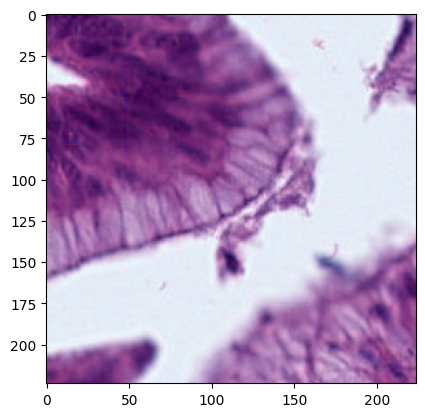

In [8]:
directory_path = './sample_Data/original_images'


image_files = os.listdir(directory_path)
image_files = sorted(image_files)

for i, image_file in enumerate(image_files):
    if(image_file.endswith('.tif')):
        img_path = os.path.join(directory_path, image_file)
        pgd_attack(img_path)